In [1]:
import os
newestModel = True #If this is set to true it will use the newest model in the models folder and ignore modelToTest
modelToTest = ''
threads = 16 #Number of threads to use for multithreaded tasks
pathToModelFolder = '~/SPGenerations/Models/'
pathToDataFolder = '~/SPDataset/S2DS129-1021DiffReposS245/'
#a folder inthe models folder contains the following files: model.h5, tokenizer.json commitHash.txt (For SCA-Tokenizer)
useCurrentSCATokenizer = '/home/mcall/SPGit/Model-Generation/SCA-Tokenizer' #If this is set to anything other than '' it will use the current SCA-Token in the SCA-Token folder and ignore the modelToTest

In [2]:
import os
import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import json
import threading as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
import subprocess
import time
import datetime
import random
import math
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import tokenizer_from_json


def homePath(path):
    return os.path.join(os.path.expanduser("~"), path.strip("~/"))

pathToModelFolder = homePath(pathToModelFolder)
pathToDataFolder = homePath(pathToDataFolder)

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()


def searchFileName(path, fileName):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == fileName:
                    filesToDo.append(os.path.join(root, file).split(path)[1])
    return filesToDo



2023-10-24 00:32:24.333409: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-24 00:32:24.367451: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 00:32:24.367475: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 00:32:24.367505: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 00:32:24.374176: I tensorflow/core/platform/cpu_feature_g

In [3]:
#File Loading

if newestModel:
    models = os.listdir(pathToModelFolder)
    models.sort()
    modelToTest = models[-1]
    print("Using newest model: " + modelToTest)
else:
    print("Using model: " + modelToTest)
model = load_model(pathToModelFolder + '/' +modelToTest + '/model.h5')
print (model.summary())

#load tokenizer from json that used the .tokenizer.save() function
with open(pathToModelFolder + '/' + modelToTest + '/tokenizer.json') as f:
    tokenizerModel = tokenizer_from_json(f.read())


Using newest model: 2023-10-17 18:59:54.067245


2023-10-24 00:32:27.092458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13173 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:11:00.0, compute capability: 8.6
2023-10-24 00:32:27.093409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13173 MB memory:  -> device: 1, name: NVIDIA A2, pci bus id: 0000:b1:00.0, compute capability: 8.6
2023-10-24 00:32:38.692390: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 1024)         10240000  
                                                                 
 conv1d (Conv1D)             (None, 398, 2048)         6293504   
                                                                 
 global_max_pooling1d (Glob  (None, 2048)              0         
 alMaxPooling1D)                                                 
                                                                 
 reshape (Reshape)           (None, 1, 2048)           0         
                                                                 
 bidirectional (Bidirection  (None, 1, 4096)           67125248  
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 4096)           0

In [4]:
#FOR MORE ADVANCED TESTS.
#pathToSCATokenizerFolder = os.getcwd() + '/SCA-Tokenizer/'
#if (not useCurrentSCATokenizer):
#    #TODO: Configure Git clone on the commit hash



In [5]:
import sys
sys.path.append('./SCA-Tokenizer/')
import TokenizerManager

dfTokens = TokenizerManager.tokenStart(pathToDataFolder, tokenizer=tokenizerModel)


completed folder index
Progressing (Not Multithreaded): |██████████████████████████████████████████████████| 100.0% Complete
Finishing
Tokenizing


In [6]:
print(dfTokens)

                                             tokenCode  \
0    [27, 787, 2, 27, 133, 2, 42, 4, 756, 4, 27, 56...   
1    [27, 787, 2, 27, 133, 2, 42, 4, 756, 4, 27, 56...   
2    [27, 787, 2, 27, 133, 2, 42, 27, 182, 2, 42, 4...   
3    [27, 787, 2, 27, 392, 2, 42, 4, 807, 27, 6646,...   
4    [27, 787, 2, 27, 392, 2, 42, 4, 807, 27, 6646,...   
..                                                 ...   
883  [27, 83, 2, 27, 3334, 2, 27, 169, 2, 27, 2, 16...   
884  [27, 2, 27, 169, 2, 27, 83, 2, 27, 3334, 2, 16...   
885  [27, 2, 27, 169, 2, 27, 83, 2, 27, 3334, 2, 16...   
886  [27, 2, 27, 169, 2, 27, 83, 2, 27, 3334, 2, 16...   
887  [27, 2, 27, 169, 2, 27, 83, 2, 27, 3334, 2, 16...   

                                      Path  
0                /3584343/conftest.py/1.py  
1                /3584343/conftest.py/0.py  
2    /3584343/tests/test_graphson2.py/0.py  
3       /3584343/tests/test_engine.py/5.py  
4       /3584343/tests/test_engine.py/1.py  
..                               

In [7]:
#Grading Code
sys.path.append('../Auto-Grader/')
import Grader

dfGrades = Grader.bootstrap(pathToDataFolder)

Noneessing Files |----------------------------------------------------------------------------------------------------| 0.0% 
908
     fileGrade                                   Path
0    40.000000              /3584343/conftest.py/0.py
1    50.000000              /3584343/conftest.py/1.py
2    40.000000  /3584343/tests/test_graphson2.py/0.py
3    40.000000     /3584343/tests/test_engine.py/0.py
4    41.538462     /3584343/tests/test_engine.py/1.py
..         ...                                    ...
903  50.000000             /3584343/docs/conf.py/5.py
904  58.000000             /3584343/docs/conf.py/6.py
905  54.000000             /3584343/docs/conf.py/7.py
906  59.000000             /3584343/docs/conf.py/8.py
907  61.000000             /3584343/docs/conf.py/9.py

[908 rows x 2 columns]
Time Taken: 0.09636926651000977


/home/mcall/SPGit/Model-Generation/../Auto-Grader/Grader.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(commitGrade, columns=['fileGrade', 'Path'])], ignore_index=True)


In [9]:
combinedDF = pd.merge(dfGrades, dfTokens, on = "Path")


In [10]:
#get max length of tokens from model
maxLen = model.layers[0].input_shape[1]

combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) <= maxLen]

#Pad the sequences
combinedDF["tokenCode"] = pad_sequences(combinedDF["tokenCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

In [16]:
#add new colum to combinedDF for the model prediction
combinedDF["predictedGrade"] = None

for i in combinedDF.index:
    combinedDF.at[i, "predictedGrade"] = model.predict(np.array([combinedDF.at[i, "tokenCode"]]))[0][0]



2023-10-24 00:40:12.178680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-24 00:40:12.771302: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 19ms/step


Accuracy: 48.9451476793249%


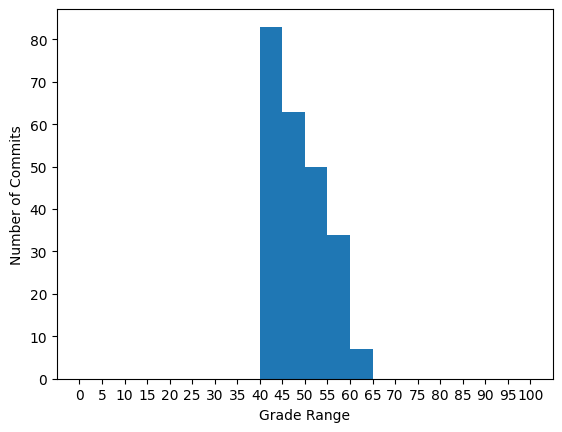

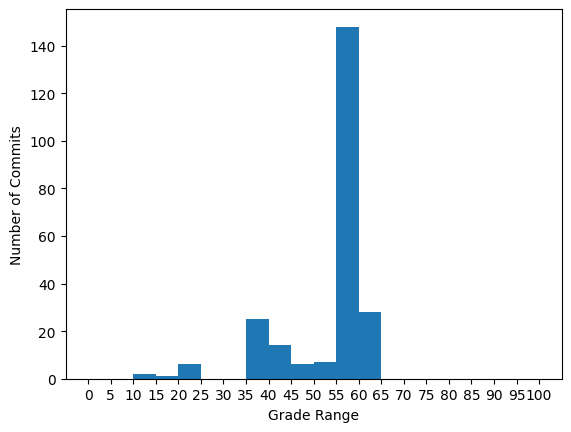

In [25]:
#check accuracy
correct = 0
total = 0
rangeofCorrect=10

for i in combinedDF.index:
    if (combinedDF.at[i, "predictedGrade"] <= combinedDF.at[i, "fileGrade"] + rangeofCorrect and combinedDF.at[i, "predictedGrade"] >= combinedDF.at[i, "fileGrade"] - rangeofCorrect):
        correct += 1
    total += 1

print ("Accuracy: " + str(correct/total * 100) + "%")

#generate graph showing range of grades
graph = plt.hist(combinedDF['fileGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()

graph = plt.hist(combinedDF['predictedGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()

